In [4]:
# Steam Price Projection - ML Analysis Notebook
# Team: Brady Huai (gh448), Harrison Hua (hyh9), Aarya Patel (avp47), Sean Lewis (shl225)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
import lightgbm as lgbm
from scipy.stats import pearsonr
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Set plotting style
sns.set_theme(style="whitegrid")  
sns.set_palette("Set2")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Steam Price Projection - ML Analysis Notebook (Enhanced)")
print("=" * 50)

Steam Price Projection - ML Analysis Notebook (Enhanced)


In [8]:
#--------------------------------------------------------------------------------
# 1. Data Loading and Integration
#--------------------------------------------------------------------------------
print("\n1. Data Loading and Integration")
print("=" * 50)
# Load the primary dataset
print("Loading games.csv dataset...")
games_df = pd.read_csv('games.csv')
print(f"Loaded {len(games_df)} games from games.csv")

# Ensure we're using the correct ID column in games_df
if 'App ID' in games_df.columns:
    games_df = games_df.rename(columns={'App ID': 'app_id'})

# Load the steamdb.json dataset
print("Loading steamdb.json dataset...")
with open('steamdb.json', 'r', encoding='utf-8') as f:
    steamdb_data = json.load(f)
   
# Convert to DataFrame
steamdb_df = pd.DataFrame(steamdb_data)
print(f"Loaded {len(steamdb_df)} games from steamdb.json")

# Print the first few records to verify we have the correct ID fields
print("\nFirst few rows of games_df (ID columns):")
if 'app_id' in games_df.columns:
    print(games_df[['app_id']].head())
else:
    print("Column 'app_id' not found in games_df")
    print("Available columns:", games_df.columns.tolist())

print("\nFirst few rows of steamdb_df (ID columns):")
if 'sid' in steamdb_df.columns:
    print(steamdb_df[['sid']].head())
else:
    print("Column 'sid' not found in steamdb_df")
    print("Available columns:", steamdb_df.columns.tolist())

# Rename key columns for merging
steamdb_df = steamdb_df.rename(columns={
    'sid': 'app_id',
    'name': 'title',
    'full_price': 'steamdb_full_price',
    'current_price': 'steamdb_current_price'
})

# Analyze ID overlap before merging
print("\nAnalyzing ID overlap before merging:")
games_ids = set(games_df['app_id'].astype(str))
steamdb_ids = set(steamdb_df['app_id'].astype(str))
overlap_ids = games_ids.intersection(steamdb_ids)
print(f"Games.csv unique IDs: {len(games_ids)}")
print(f"SteamDB.json unique IDs: {len(steamdb_ids)}")
print(f"Overlapping IDs (games in both datasets): {len(overlap_ids)}")
print(f"Overlap percentage: {len(overlap_ids) / min(len(games_ids), len(steamdb_ids)):.2%}")

# First, ensure app_id is the same type in both dataframes
games_df['app_id'] = games_df['app_id'].astype(str)
steamdb_df['app_id'] = steamdb_df['app_id'].astype(str)

# Merge on app_id
print("\nMerging datasets...")
merged_df = pd.merge(games_df, steamdb_df, on='app_id', how='outer', suffixes=('', '_steamdb'))

# Check for actual duplicate app_ids in the merged result
print("Checking for duplicate app_ids in merged dataset...")
app_id_counts = merged_df['app_id'].value_counts()
duplicate_app_ids = app_id_counts[app_id_counts > 1].index.tolist()
print(f"Found {len(duplicate_app_ids)} duplicate app_ids in the merged dataset")

# If there are duplicates in the merged result, handle them
if duplicate_app_ids:
    print("Handling duplicate app_ids...")
    for app_id in duplicate_app_ids:
        dupes = merged_df[merged_df['app_id'] == app_id].copy()
        # Count non-null values for each row
        dupes['non_nulls'] = dupes.notna().sum(axis=1)
        # Keep the row with the most non-null values
        keep_idx = dupes['non_nulls'].idxmax()
        # Drop duplicates except the one we want to keep
        drop_idx = dupes.index[dupes.index != keep_idx]
        merged_df = merged_df.drop(drop_idx)
    
    # Drop the temporary column
    if 'non_nulls' in merged_df.columns:
        merged_df = merged_df.drop('non_nulls', axis=1)

# Reset index
merged_df = merged_df.reset_index(drop=True)
print(f"Final merged dataset contains {len(merged_df)} unique rows")

# Display basic information
print("\nMerged Dataset Info:")
print(f"Number of columns: {merged_df.shape[1]}")
print(f"Memory usage: {merged_df.memory_usage().sum() / 1024**2:.2f} MB")

# Basic statistics on numeric columns
print("\nBasic Statistics (numeric columns):")
print(merged_df.describe().T)

# Rename columns for key_columns check if needed
if 'Reviews Score Fancy' in merged_df.columns and 'reviews_score_fancy' not in merged_df.columns:
    merged_df = merged_df.rename(columns={'Reviews Score Fancy': 'reviews_score_fancy'})
if 'Launch Price' in merged_df.columns and 'launch_price' not in merged_df.columns:
    merged_df = merged_df.rename(columns={'Launch Price': 'launch_price'})
if 'Revenue Estimated' in merged_df.columns and 'revenue_estimated' not in merged_df.columns:
    merged_df = merged_df.rename(columns={'Revenue Estimated': 'revenue_estimated'})

# Check for missing values in key columns
print("\nMissing Values in Key Columns:")
key_columns = ['app_id', 'title', 'launch_price', 'steamdb_full_price',
               'reviews_score_fancy', 'meta_score', 'igdb_score', 'revenue_estimated']
# Only check columns that actually exist in the DataFrame
existing_key_columns = [col for col in key_columns if col in merged_df.columns]
print(merged_df[existing_key_columns].isnull().sum())

# Use the merged dataset for analysis
df = merged_df.copy()


1. Data Loading and Integration
Loading games.csv dataset...
Loaded 65111 games from games.csv
Loading steamdb.json dataset...
Loaded 53981 games from steamdb.json

First few rows of games_df (ID columns):
   app_id
0     730
1  578080
2     570
3  271590
4  359550

First few rows of steamdb_df (ID columns):
   sid
0   10
1   20
2   30
3   40
4   50

Analyzing ID overlap before merging:
Games.csv unique IDs: 65109
SteamDB.json unique IDs: 53981
Overlapping IDs (games in both datasets): 47609
Overlap percentage: 88.20%

Merging datasets...
Checking for duplicate app_ids in merged dataset...
Found 2 duplicate app_ids in the merged dataset
Handling duplicate app_ids...
Final merged dataset contains 71481 unique rows

Merged Dataset Info:
Number of columns: 59
Memory usage: 32.18 MB

Basic Statistics (numeric columns):
                         count           mean           std      min      25%      50%       75%           max
Reviews Total          65109.0    1198.135895  3.411528e+04  

In [12]:
#--------------------------------------------------------------------------------
# 2. Data Preprocessing
#--------------------------------------------------------------------------------

print("\n2. Data Preprocessing")
print("=" * 50)

# Clean column names - replace spaces with underscores and make lowercase
df.columns = [col.replace(' ', '_').lower() for col in df.columns]

# Convert columns that need to be numeric first, before any operations
# This helps prevent TypeErrors later
if 'reviews_total' in df.columns:
    df['reviews_total'] = pd.to_numeric(df['reviews_total'], errors='coerce')

# Extract numeric values from price strings
def extract_price(price_str):
    if pd.isna(price_str):
        return np.nan
    price_str = str(price_str)
    # Remove $ and other currency symbols, replace commas with dots
    price_str = re.sub(r'[^\d.,]', '', price_str).replace(',', '.')
    # Find the first valid number
    match = re.search(r'(\d+(\.\d+)?)', price_str)
    if match:
        return float(match.group(1))
    return np.nan

# Clean price columns
price_columns = ['launch_price', 'steamdb_full_price', 'steamdb_current_price']
for col in price_columns:
    if col in df.columns:
        df[col] = df[col].apply(extract_price)

# Combine price data - use steamdb_full_price if launch_price is missing
if 'launch_price' in df.columns and 'steamdb_full_price' in df.columns:
    df['combined_price'] = df['launch_price']
    mask = df['combined_price'].isna() & df['steamdb_full_price'].notna()
    df.loc[mask, 'combined_price'] = df.loc[mask, 'steamdb_full_price']

# Convert date columns to datetime
date_columns = [col for col in ['release_date', 'published_store', 'published_meta', 'published_igdb'] 
                if col in df.columns]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Use earliest available date as release date
if date_columns:  # Only if we have any date columns
    df['earliest_release_date'] = df[date_columns].min(axis=1)

    # Calculate game age in days (from release to current date)
    current_date = datetime(2025, 4, 20)  # Current date from the context
    for date_col in [col for col in ['release_date', 'earliest_release_date'] if col in df.columns]:
        df[f'{date_col}_age_days'] = (current_date - df[date_col]).dt.days

    # Extract year and month from release date
    for date_col in [col for col in ['release_date', 'earliest_release_date'] if col in df.columns]:
        df[f'{date_col}_year'] = df[date_col].dt.year
        df[f'{date_col}_month'] = df[date_col].dt.month
        df[f'{date_col}_quarter'] = df[date_col].dt.quarter

# Process review scores - normalize all scores to 0-1 scale
review_columns = {
    'reviews_score_fancy': 100,  # Assumed to be on a 0-100 scale
    'meta_score': 100,           # Metacritic score is 0-100
    'meta_uscore': 100,          # Metacritic user score is 0-100
    'igdb_score': 100,           # IGDB score is 0-100
    'igdb_uscore': 100,          # IGDB user score is 0-100
    'gfq_rating': 5              # GameFAQs rating might be on a 0-5 scale
}

for col, max_val in review_columns.items():
    if col in df.columns:
        # First convert to numeric, safely handling all types
        try:
            if col == 'reviews_score_fancy':
                # Handle percentage strings like "88%"
                df[col] = df[col].astype(str).str.replace('%', '').astype(float)
            else:
                # Convert other columns to numeric
                df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Now perform normalization
            df[f'{col}_norm'] = df[col] / max_val
        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")
            # Create empty normalized column to prevent errors later
            df[f'{col}_norm'] = np.nan

# Create a combined review score (weighted average of available scores)
score_columns = [f'{col}_norm' for col in review_columns.keys() 
                if f'{col}_norm' in df.columns and not df[f'{col}_norm'].isna().all()]

weights = {
    'reviews_score_fancy_norm': 0.4,  # Steam reviews (highest weight)
    'meta_score_norm': 0.2,           # Metacritic critic score
    'igdb_score_norm': 0.2,           # IGDB score
    'meta_uscore_norm': 0.1,          # Metacritic user score
    'igdb_uscore_norm': 0.1           # IGDB user score
}

# Adjusted weights for available columns
available_weights = {k: v for k, v in weights.items() if k in score_columns}
weight_sum = sum(available_weights.values())
normalized_weights = {k: v/weight_sum for k, v in available_weights.items()} if weight_sum > 0 else {}

# Calculate weighted average score
if score_columns and normalized_weights:
    df['combined_score'] = 0
    for col, weight in normalized_weights.items():
        df['combined_score'] += df[col].fillna(0) * weight
    
    # Normalize to account for missing values
    score_count = df[score_columns].notna().sum(axis=1)
    valid_scores_mask = score_count > 0
    if valid_scores_mask.any():
        df.loc[valid_scores_mask, 'combined_score'] = df.loc[valid_scores_mask, 'combined_score'] * len(normalized_weights) / score_count.loc[valid_scores_mask]

# Process tags, genres, and categories (simplified for robustness)
def process_tag_field(df, field_name):
    if field_name not in df.columns:
        print(f"Column {field_name} not found in dataframe")
        return df
    
    try:
        # Create count feature (simplified)
        df[f'{field_name}_count'] = df[field_name].fillna('').astype(str).apply(
            lambda x: len([t for t in x.split(',') if t.strip()])
        )
        
        # No further processing for now to avoid potential errors
        return df
    except Exception as e:
        print(f"Error processing {field_name}: {str(e)}")
        return df

# Process only essential tag fields
tag_fields = [field for field in ['tags', 'genres', 'categories'] if field in df.columns]
for field in tag_fields:
    df = process_tag_field(df, field)

# Process developer and publisher information (simplified)
for field in [f for f in ['developers', 'publishers'] if f in df.columns]:
    try:
        # Count games per developer/publisher
        counts = df[field].value_counts()
        
        # Add developer/publisher size as a feature
        df[f'{field}_size'] = df[field].map(counts.to_dict())
    except Exception as e:
        print(f"Error processing {field}: {str(e)}")

# Process achievements
if 'achievements' in df.columns:
    # Convert to numeric first, then fill NaN values with 0
    df['achievements'] = pd.to_numeric(df['achievements'], errors='coerce').fillna(0)

# Skip NLP and complex processing to avoid potential errors

# Basic safe feature engineering
# Feature Engineering: Ownership and Popularity metrics
if 'stsp_owners' in df.columns:
    df['stsp_owners'] = pd.to_numeric(df['stsp_owners'], errors='coerce').fillna(0)

# Feature Engineering: Game length metrics
length_columns = [col for col in ['hltb_single', 'hltb_complete'] if col in df.columns]
for col in length_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Feature Engineering: Game complexity (ratio of completion to single playthrough)
if all(col in df.columns for col in ['hltb_complete', 'hltb_single']):
    try:
        mask = (df['hltb_single'] > 0) & (df['hltb_complete'] > 0)
        df.loc[mask, 'completion_ratio'] = df.loc[mask, 'hltb_complete'] / df.loc[mask, 'hltb_single']
    except Exception as e:
        print(f"Error calculating completion_ratio: {str(e)}")

# Feature Engineering: Reviews per day (safe version)
if all(col in df.columns for col in ['reviews_total', 'release_date_age_days']):
    try:
        mask = df['release_date_age_days'] > 0
        df.loc[mask, 'reviews_per_day'] = df.loc[mask, 'reviews_total'] / df.loc[mask, 'release_date_age_days']
    except Exception as e:
        print(f"Error calculating reviews_per_day: {str(e)}")

# Drop rows with missing critical values (only app_id is truly critical)
critical_columns = ['app_id']
df_clean = df.dropna(subset=critical_columns)

print(f"\nOriginal merged dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")

# Replace the original dataframe with the cleaned one
df = df_clean

# Reset index
df.reset_index(drop=True, inplace=True)

# Print sample statistics to verify data types
print("\nSample column data types:")
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()[:5]  # First 5 numeric columns
for col in numeric_cols:
    print(f"{col}: {df[col].dtype}, non-null count: {df[col].count()}, sample values: {df[col].dropna().head(3).tolist()}")


2. Data Preprocessing
Error processing column reviews_score_fancy: could not convert string to float: '89,85'
Error processing tags: 'Series' object has no attribute 'split'

Original merged dataset shape: (71481, 82)
Cleaned dataset shape: (71481, 82)
Rows removed: 0

Sample column data types:
reviews_total: float64, non-null count: 65109, sample values: [7382695.0, 2201296.0, 2017009.0]
reviews_d7: float64, non-null count: 0, sample values: []
reviews_d30: float64, non-null count: 0, sample values: []
reviews_d90: float64, non-null count: 0, sample values: []
launch_price: float64, non-null count: 65109, sample values: [14.0, 29.0, 29.0]


In [15]:
#--------------------------------------------------------------------------------
# 3. Exploratory Data Analysis
#--------------------------------------------------------------------------------

print("\n3. Exploratory Data Analysis")
print("=" * 50)

# Ensure numeric columns are properly converted before plotting
for col in ['combined_price', 'revenue_estimated', 'release_date_age_days', 'hltb_single']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fix the price scaling issue
# For steamdb.json, prices might be represented as 1000 for $10.00, 2000 for $20.00, etc.
# Check for unrealistic values and apply scaling if needed
if 'combined_price' in df.columns:
    # Create a temporary copy to explore price distribution
    price_stats = df['combined_price'].dropna()
    price_median = price_stats.median()
    price_max = price_stats.max()
    
    print(f"Initial price statistics - Median: ${price_median:.2f}, Max: ${price_max:.2f}")
    
    # If the median or max price is unrealistically high, we need to scale
    if price_median > 60 or price_max > 200:
        print("Detecting unrealistic price values, applying scaling correction...")
        # Apply scaling factor of 1/100 for values that appear to be in cents
        price_factor = 0.01
        
        # Apply the correction to all price columns
        for col in ['combined_price', 'launch_price', 'steamdb_full_price', 'steamdb_current_price']:
            if col in df.columns:
                # Only apply scaling to values above realistic threshold ($200)
                high_prices_mask = df[col] > 200
                df.loc[high_prices_mask, col] = df.loc[high_prices_mask, col] * price_factor
        
        # Update price-related derived columns
        if 'price_per_hour' in df.columns:
            df['price_per_hour'] = df['price_per_hour'] * price_factor
        if 'price_to_score_ratio' in df.columns:
            df['price_to_score_ratio'] = df['price_to_score_ratio'] * price_factor
        
        # Print updated stats
        print(f"Updated price statistics - Median: ${df['combined_price'].median():.2f}, Max: ${df['combined_price'].max():.2f}")
    
    # After scaling, enforce the $200 max price for Steam games
    max_price_mask = df['combined_price'] > 200
    if max_price_mask.sum() > 0:
        print(f"Removing {max_price_mask.sum()} games with prices still above $200 after scaling...")
        df = df[~max_price_mask].copy()

# Check if required columns are available before plotting
if 'combined_price' in df.columns and 'revenue_estimated' in df.columns:
    # Create a filtered dataframe to avoid NaN values causing errors
    plot_df = df.dropna(subset=['combined_price', 'revenue_estimated'])
    
    if len(plot_df) > 0:  # Only proceed if we have data to plot
        # Relationship between price and revenue
        plt.figure(figsize=(10, 6))
        plt.scatter(plot_df['combined_price'], plot_df['revenue_estimated'], alpha=0.6)
        plt.title('Price vs. Estimated Revenue')
        plt.xlabel('Price ($)')
        plt.ylabel('Estimated Revenue ($)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('price_vs_revenue.png')
        plt.close()  # Close figure to free memory

# Distribution of Prices
if 'combined_price' in df.columns:
    valid_prices = df['combined_price'].dropna()
    if len(valid_prices) > 0:
        plt.figure(figsize=(10, 6))
        # Use a more appropriate number of bins for the $0-200 range
        sns.histplot(valid_prices, bins=40)
        plt.title('Distribution of Game Prices on Steam')
        plt.xlabel('Price ($)')
        plt.ylabel('Number of Games')
        plt.xlim(0, 200)  # Set x-axis limit to realistic Steam price range
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('price_distribution.png')
        plt.close()
        
        # Also create a zoomed-in view of the most common price points
        plt.figure(figsize=(10, 6))
        sns.histplot(valid_prices[valid_prices <= 60], bins=30)
        plt.title('Distribution of Common Game Prices on Steam (≤ $60)')
        plt.xlabel('Price ($)')
        plt.ylabel('Number of Games')
        plt.xticks(range(0, 65, 5))  # Set x-ticks every $5
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('common_price_distribution.png')
        plt.close()

# Relationship between combined review score and revenue
if all(col in df.columns for col in ['combined_score', 'revenue_estimated']):
    plot_df = df.dropna(subset=['combined_score', 'revenue_estimated'])
    if len(plot_df) > 0:
        plt.figure(figsize=(10, 6))
        plt.scatter(plot_df['combined_score'], plot_df['revenue_estimated'], alpha=0.6)
        plt.title('Combined Review Score vs. Estimated Revenue')
        plt.xlabel('Combined Review Score (0-1)')
        plt.ylabel('Estimated Revenue ($)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('review_score_vs_revenue.png')
        plt.close()

# Relationship between game age and price
if all(col in df.columns for col in ['release_date_age_days', 'combined_price']):
    plot_df = df.dropna(subset=['release_date_age_days', 'combined_price'])
    if len(plot_df) > 0:
        plt.figure(figsize=(10, 6))
        plt.scatter(plot_df['release_date_age_days'], plot_df['combined_price'], alpha=0.6)
        plt.title('Game Age vs. Price')
        plt.xlabel('Game Age (Days)')
        plt.ylabel('Price ($)')
        plt.ylim(0, 200)  # Set y-axis limit to realistic Steam price range
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('game_age_vs_price.png')
        plt.close()

# Revenue by release year
if all(col in df.columns for col in ['release_date_year', 'revenue_estimated']):
    try:
        df['release_date_year'] = pd.to_numeric(df['release_date_year'], errors='coerce')
        plot_df = df.dropna(subset=['release_date_year', 'revenue_estimated'])
        
        if len(plot_df) > 0:
            yearly_revenue = plot_df.groupby('release_date_year')['revenue_estimated'].mean().reset_index()
            if len(yearly_revenue) > 0:
                plt.figure(figsize=(12, 6))
                sns.barplot(x='release_date_year', y='revenue_estimated', data=yearly_revenue)
                plt.title('Average Revenue by Release Year')
                plt.xlabel('Release Year')
                plt.ylabel('Average Estimated Revenue ($)')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig('revenue_by_year.png')
                plt.close()
    except Exception as e:
        print(f"Error plotting revenue by year: {str(e)}")

# Price comparison by platform
platform_cols = [col for col in df.columns if col.startswith('platform_')]
if platform_cols:
    try:
        platform_prices = {}
        for col in platform_cols:
            platform = col.replace('platform_', '')
            games_on_platform = df[df[col] == 1].dropna(subset=['combined_price'])
            if len(games_on_platform) > 10:  # Only include platforms with enough games
                platform_prices[platform] = games_on_platform['combined_price'].mean()
        
        if platform_prices:
            plt.figure(figsize=(10, 6))
            plt.bar(platform_prices.keys(), platform_prices.values())
            plt.title('Average Price by Platform')
            plt.xlabel('Platform')
            plt.ylabel('Average Price ($)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('price_by_platform.png')
            plt.close()
    except Exception as e:
        print(f"Error plotting price by platform: {str(e)}")

# Price vs. Game Length (if data available)
if all(col in df.columns for col in ['combined_price', 'hltb_single']):
    try:
        mask = (df['hltb_single'] > 0) & (df['hltb_single'] < 100) & (df['combined_price'] > 0)
        plot_df = df.loc[mask]
        
        if len(plot_df) > 0:
            plt.figure(figsize=(10, 6))
            plt.scatter(plot_df['hltb_single'], plot_df['combined_price'], alpha=0.6)
            plt.title('Game Length vs. Price')
            plt.xlabel('Main Story Length (Hours)')
            plt.ylabel('Price ($)')
            plt.ylim(0, 200)  # Set y-axis limit to realistic Steam price range
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('game_length_vs_price.png')
            plt.close()
    except Exception as e:
        print(f"Error plotting game length vs price: {str(e)}")

# Price per Hour vs. Revenue
if all(col in df.columns for col in ['price_per_hour', 'revenue_estimated']):
    try:
        # Convert to numeric and filter
        df['price_per_hour'] = pd.to_numeric(df['price_per_hour'], errors='coerce')
        mask = (df['price_per_hour'] > 0) & (df['price_per_hour'] < 10)
        plot_df = df.loc[mask].dropna(subset=['revenue_estimated'])
        
        if len(plot_df) > 0:
            plt.figure(figsize=(10, 6))
            plt.scatter(plot_df['price_per_hour'], plot_df['revenue_estimated'], alpha=0.6)
            plt.title('Price per Hour vs. Estimated Revenue')
            plt.xlabel('Price per Hour ($)')
            plt.ylabel('Estimated Revenue ($)')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('price_per_hour_vs_revenue.png')
            plt.close()
    except Exception as e:
        print(f"Error plotting price per hour vs revenue: {str(e)}")

# Top performing genres by average revenue
genre_cols = [col for col in df.columns if col.startswith('genres_')]
if genre_cols and 'revenue_estimated' in df.columns:
    try:
        genre_performance = {}
        
        for col in genre_cols:
            genre_name = col.replace('genres_', '')
            games_with_genre = df[df[col] == 1].dropna(subset=['revenue_estimated'])
            if len(games_with_genre) > 10:  # Only consider genres with at least 10 games
                genre_performance[genre_name] = games_with_genre['revenue_estimated'].mean()
        
        if genre_performance:
            # Sort and plot top 10 genres by average revenue
            genre_performance = pd.Series(genre_performance).sort_values(ascending=False).head(10)
            plt.figure(figsize=(12, 6))
            genre_performance.plot(kind='bar')
            plt.title('Top 10 Genres by Average Revenue')
            plt.xlabel('Genre')
            plt.ylabel('Average Estimated Revenue ($)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('genre_revenue_performance.png')
            plt.close()
    except Exception as e:
        print(f"Error plotting genre performance: {str(e)}")

# Correlation matrix for key numeric features
try:
    numeric_features = [
        'combined_price', 'combined_score', 'reviews_total', 
        'release_date_age_days', 'achievements', 'stsp_owners',
        'revenue_estimated'
    ]

    # Filter to only include columns that exist in the dataframe and are numeric
    numeric_features = [col for col in numeric_features if col in df.columns]
    
    # Convert all to numeric explicitly
    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Use only rows with complete data for correlation
    corr_df = df[numeric_features].dropna()
    
    if len(corr_df) > 0 and len(numeric_features) > 1:
        corr_matrix = corr_df.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix of Key Features')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        plt.close()
except Exception as e:
    print(f"Error creating correlation matrix: {str(e)}")

print("EDA completed successfully. Check the output directory for generated plots.")


3. Exploratory Data Analysis
Initial price statistics - Median: $6.00, Max: $12999.00
Detecting unrealistic price values, applying scaling correction...
Updated price statistics - Median: $6.00, Max: $199.00
EDA completed successfully. Check the output directory for generated plots.


In [56]:
#--------------------------------------------------------------------------------
# 4. Feature Selection and Model Preparation (Overhauled) - Fixed
#--------------------------------------------------------------------------------
print("\n4. Feature Selection and Model Preparation (Overhauled)")
print("=" * 50)

import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_regression

############################################################
# 1) BASIC DATA CLEANUP & TARGET DEFINITION
############################################################

target_column = 'combined_price'

# Ensure the target is numeric
if target_column in df.columns:
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
else:
    print(f"Error: Target column '{target_column}' not found. Attempting fallback...")
    for col in ['combined_price','launch_price','steamdb_full_price','revenue_estimated']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            target_column = col
            break

# Drop rows with missing target
print(f"Removing rows with missing values in target variable '{target_column}'...")
df_model = df.dropna(subset=[target_column]).copy()
print(f"Rows remaining after removing missing target values: {len(df_model)}")

# Fix duplicate column names (if any)
df_columns = list(df_model.columns)
dup_cols = [col for col in set(df_columns) if df_columns.count(col) > 1]
if dup_cols:
    print(f"Found duplicate column names: {dup_cols}")
    new_cols = []
    col_counts = {}
    for col in df_columns:
        if col in col_counts:
            col_counts[col] += 1
            new_cols.append(f"{col}_{col_counts[col]}")
        else:
            col_counts[col] = 1
            new_cols.append(col)
    df_model.columns = new_cols

############################################################
# 2) OUTLIER REMOVAL (TIGHTER IQR THRESHOLD)
############################################################

# More stringent IQR approach
q1 = df_model[target_column].quantile(0.01)
q3 = df_model[target_column].quantile(0.99)
iqr = q3 - q1
# Tighter caps: 1.0 * IQR (instead of 1.5)
lower_bound = max(0, q1 - 1.0 * iqr)   # Price cannot be negative
upper_bound = min(80, q3 + 1.0 * iqr) # Hard cap at 80 to remove extreme skew

print(f"\nOutlier detection for {target_column}:")
print(f"Lower bound: ${lower_bound:.2f}, Upper bound: ${upper_bound:.2f}")
count_outliers = df_model[(df_model[target_column] < lower_bound) | 
                          (df_model[target_column] > upper_bound)].shape[0]
print(f"Rows with outlier prices: {count_outliers}")

# Remove outliers
df_model = df_model[(df_model[target_column] >= lower_bound) & 
                    (df_model[target_column] <= upper_bound)]
print(f"Rows after outlier removal: {len(df_model)}")

# Basic stats on the target distribution
print("\nTarget distribution after outlier removal:")
print(f"Mean price:  ${df_model[target_column].mean():.2f}")
print(f"Median price: ${df_model[target_column].median():.2f}")
print(f"Min price:    ${df_model[target_column].min():.2f}")
print(f"Max price:    ${df_model[target_column].max():.2f}")

# Create log-transformed target
df_model['log_price'] = np.log1p(df_model[target_column])

# Price categories in $5 intervals
price_bins = [0, 5, 10, 15, 20, 25, 30, float('inf')]
price_labels = ['$0-5','$5-10','$10-15','$15-20','$20-25','$25-30','$30+']
df_model['price_category'] = pd.cut(df_model[target_column], bins=price_bins, labels=price_labels)

# Drop rows with NaN category if any
null_cat_count = df_model['price_category'].isna().sum()
if null_cat_count > 0:
    df_model.dropna(subset=['price_category'], inplace=True)

# Stratification bucket
df_model['price_bucket'] = pd.qcut(df_model[target_column], 5, labels=False)

############################################################
# 3) TEXT FEATURE EXTRACTION (e.g. from 'tags' or 'title')
############################################################

start_time = time.time()
print("\nExtracting text features from 'tags' or 'title'...")

df_model['text_combo'] = ''
if 'tags' in df_model.columns:
    df_model['tags'] = df_model['tags'].fillna('')
    df_model['text_combo'] += df_model['tags'].astype(str) + ' '

if 'title' in df_model.columns:
    df_model['title'] = df_model['title'].fillna('')
    df_model['text_combo'] += df_model['title'].astype(str)

text_vector_cols = []  # will hold TF–IDF feature names
if df_model['text_combo'].str.strip().nunique() > 1:
    tfidf = TfidfVectorizer(max_features=300, stop_words='english')
    X_text = tfidf.fit_transform(df_model['text_combo'])
    text_vector_cols = tfidf.get_feature_names_out()
    
    # Convert to DataFrame
    df_text = pd.DataFrame(X_text.toarray(), columns=text_vector_cols, index=df_model.index)
    # Merge back into df_model
    df_model = pd.concat([df_model, df_text], axis=1)
else:
    print("No text data found or minimal variability. Skipping TF–IDF feature extraction.")

print(f"Text feature extraction completed in {time.time() - start_time:.2f} s. "
      f"TF–IDF features added: {len(text_vector_cols)}")

############################################################
# 4) NUMERIC FEATURE ENGINEERING
############################################################

print("\nPerforming numeric feature engineering...")

# Log transforms for skewed numeric fields
log_candidates = ['reviews_total','stsp_owners','reviews_per_day']
for col in log_candidates:
    if col in df_model.columns:
        df_model[f'{col}_log'] = np.log1p(df_model[col].fillna(0))

# Create game age buckets, recency score, etc.
if 'release_date_age_days' in df_model.columns:
    df_model['recency_score'] = 1 / (1 + np.log1p(df_model['release_date_age_days'].fillna(0)))
    df_model['age_years'] = df_model['release_date_age_days'] / 365.0

    df_model['age_lt_30d'] = (df_model['release_date_age_days'] < 30).astype(int)
    df_model['age_30d_90d'] = ((df_model['release_date_age_days'] >= 30) & 
                              (df_model['release_date_age_days'] < 90)).astype(int)
    df_model['age_90d_1y'] = ((df_model['release_date_age_days'] >= 90) & 
                              (df_model['release_date_age_days'] < 365)).astype(int)
    df_model['age_1y_3y'] = ((df_model['release_date_age_days'] >= 365) & 
                             (df_model['release_date_age_days'] < 1095)).astype(int)
    df_model['age_gt_3y'] = (df_model['release_date_age_days'] >= 1095).astype(int)

# Combined score expansions
if 'combined_score' in df_model.columns:
    df_model['combined_score_squared'] = df_model['combined_score'] ** 2
    df_model['score_age_interaction'] = df_model['combined_score'] * df_model.get('recency_score', 1)
    
    if 'reviews_total_log' in df_model.columns:
        df_model['score_review_interaction'] = df_model['combined_score'] * df_model['reviews_total_log']

# Achievements
if 'achievements' in df_model.columns:
    df_model['achievements_log'] = np.log1p(df_model['achievements'])
    df_model['has_achievements'] = (df_model['achievements'] > 0).astype(int)

# "content_scope" = genres_count + categories_count
if all(col in df_model.columns for col in ['genres_count','categories_count']):
    df_model['content_scope'] = df_model['genres_count'] + df_model['categories_count']

# Additional ratio features
if 'combined_score' in df_model.columns and 'reviews_total' in df_model.columns:
    df_model['reviews_total_safe'] = df_model['reviews_total'].fillna(0).replace(0,1)
    df_model['review_score_ratio'] = df_model['combined_score'] / np.log1p(df_model['reviews_total_safe'])

# Potential numeric features
candidate_numeric = [
    'reviews_total','combined_score','achievements','release_date_age_days',
    'reviews_per_day','hltb_single','stsp_owners','categories_count','genres_count',
    'reviews_total_log','stsp_owners_log','reviews_per_day_log','achievements_log',
    'combined_score_squared','recency_score','age_years','score_age_interaction',
    'score_review_interaction','review_score_ratio','content_scope','age_lt_30d',
    'age_30d_90d','age_90d_1y','age_1y_3y','age_gt_3y','has_achievements'
]

# Keep only existing columns
candidate_numeric = [c for c in candidate_numeric if c in df_model.columns]

############################################################
# 5) ADVANCED FEATURE SELECTION: CORRELATION + MUTUAL INFO
############################################################

print("\nApplying correlation + mutual info for feature selection...")

# 5a) Drop features with extremely low correlation to price
spearman_corr = df_model[candidate_numeric + [target_column]].corr(method='spearman')[target_column].abs()
low_corr_threshold = 0.01
low_corr_feats = spearman_corr[spearman_corr < low_corr_threshold].index.tolist()
if low_corr_feats:
    print(f"Dropping low-corr feats: {low_corr_feats}")
candidate_numeric = [f for f in candidate_numeric if f not in low_corr_feats]

# 5b) Mutual Information for regression
X_temp = df_model[candidate_numeric].fillna(0)
y_temp = df_model[target_column]
mi_scores = mutual_info_regression(X_temp, y_temp, random_state=42)
mi_series = pd.Series(mi_scores, index=candidate_numeric).sort_values(ascending=False)

print("\nTop features by mutual info (regression):")
print(mi_series.head(15))

# Keep only features above a certain MI threshold
mi_cutoff = 0.002
candidate_numeric = mi_series[mi_series > mi_cutoff].index.tolist()
print(f"\nFinal selected numeric features ({len(candidate_numeric)}): {candidate_numeric}")

############################################################
# 6) OPTIONAL POLYNOMIAL FEATURES FOR TOP CORRELATED
############################################################

print("\nCreating polynomial interactions among top 3 correlated features...")

top_corr_feats = spearman_corr.drop(labels=[target_column]).sort_values(ascending=False).head(3).index.tolist()
from itertools import combinations
for f1, f2 in combinations(top_corr_feats, 2):
    if f1 in candidate_numeric and f2 in candidate_numeric:
        inter_name = f"{f1}X{f2}"
        df_model[inter_name] = df_model[f1] * df_model[f2]
        candidate_numeric.append(inter_name)

############################################################
# 7) CATEGORICAL FEATURES
############################################################

candidate_categorical = []  # or define your categorical features here

# Fix the TF–IDF features assignment to avoid ambiguous truth value
if text_vector_cols is not None and len(text_vector_cols) > 0:
    tfidf_features = list(text_vector_cols)
else:
    tfidf_features = []

all_features = candidate_numeric + tfidf_features + candidate_categorical

############################################################
# 8) MISSING VALUE IMPUTATION
############################################################

print("\nChecking missing values among final features...")
missing_counts = df_model[all_features].isna().sum()
missing_counts = missing_counts[missing_counts > 0]
if not missing_counts.empty:
    print(missing_counts)
else:
    print("No missing values in final features.")

print("\nImputing missing values with median for numeric, zero for TF–IDF text...")
for col in all_features:
    if col in candidate_numeric:
        df_model[col] = df_model[col].fillna(df_model[col].median())
    elif col in tfidf_features:
        df_model[col] = df_model[col].fillna(0)

############################################################
# 9) SPLIT FOR REGRESSION & CLASSIFICATION
############################################################

X = df_model[all_features].copy()
y_reg = df_model[target_column].copy()
y_log = df_model['log_price'].copy()
y_cat = df_model['price_category'].copy()

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Regression target shape:  {y_reg.shape}")
print(f"Log target shape:        {y_log.shape}")
print(f"Classification target:   {y_cat.shape}")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42, stratify=df_model['price_bucket']
)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df_model['price_bucket']
)

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print(f"Train size: {len(X_train_reg)}, Test size: {len(X_test_reg)}")

############################################################
# 10) SCALING NUMERIC FEATURES
############################################################

print("\nScaling numeric features...")
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_mask = [col in candidate_numeric for col in X_train_reg.columns]

X_train_reg_scaled = X_train_reg.copy()
X_test_reg_scaled = X_test_reg.copy()

X_train_reg_scaled.loc[:, numeric_mask] = scaler.fit_transform(X_train_reg_scaled.loc[:, numeric_mask])
X_test_reg_scaled.loc[:, numeric_mask] = scaler.transform(X_test_reg_scaled.loc[:, numeric_mask])

print("\nFeature preparation complete (overhauled & fixed).")



4. Feature Selection and Model Preparation (Overhauled)
Removing rows with missing values in target variable 'combined_price'...
Rows remaining after removing missing target values: 65329
Found duplicate column names: ['tags', 'title']

Outlier detection for combined_price:
Lower bound: $0.00, Upper bound: $80.00
Rows with outlier prices: 260
Rows after outlier removal: 65069

Target distribution after outlier removal:
Mean price:  $8.91
Median price: $6.00
Min price:    $0.00
Max price:    $79.00

Extracting text features from 'tags' or 'title'...
Text feature extraction completed in 1.78 s. TF–IDF features added: 300

Performing numeric feature engineering...

Applying correlation + mutual info for feature selection...
Dropping low-corr feats: ['age_90d_1y']

Top features by mutual info (regression):
reviews_per_day_log         0.110519
reviews_per_day             0.107037
reviews_total_log           0.102314
reviews_total               0.100701
release_date_age_days       0.079410


In [ ]:
#--------------------------------------------------------------------------------
# 5. Model Development and Evaluation (Overhauled)
#--------------------------------------------------------------------------------
print("\n5. Model Development and Evaluation (Overhauled)")
print("=" * 50)

import numpy as np
import pandas as pd
import time
from tqdm.auto import tqdm
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_percentage_error, 
    classification_report, accuracy_score
)
from sklearn.model_selection import (
    cross_val_score, KFold, RandomizedSearchCV
)

try:
    import xgboost as xgb
    import lightgbm as lgbm
except ImportError:
    print("XGBoost or LightGBM not installed. Some models will be skipped.")

#----------------------------------------------------
# Hyperparameter Grids
#----------------------------------------------------
param_dist_xgb = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}
param_dist_lgb = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}

#----------------------------------------------------
# Results containers
#----------------------------------------------------
reg_results = {}
log_results = {}
clf_results = {}
segment_results = {}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

#----------------------------------------------------
# Evaluation Helpers
#----------------------------------------------------
def evaluate_regression(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    valid_idx = (np.abs(y_true) > 1e-5)
    mape = mean_absolute_percentage_error(y_true[valid_idx], y_pred[valid_idx])
    r2 = r2_score(y_true, y_pred)

    ape = np.abs((y_true[valid_idx] - y_pred[valid_idx]) / y_true[valid_idx])
    min_ape = ape.min()
    median_ape = np.median(ape)
    max_ape = ape.max()
    p90_ape = np.percentile(ape, 90)
    extreme_count = (ape > 1.0).sum()
    extreme_pct = extreme_count / len(ape) * 100

    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2f}, R2: {r2:.2f}")
    print(f"APE stats -> Min: {min_ape:.4f}, Median: {median_ape:.4f}, Max: {max_ape:.4f}, 90th: {p90_ape:.4f}")
    print(f"Samples w/ >100% error: {extreme_count} ({extreme_pct:.1f}%)\n")

    return {
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'MinAPE': min_ape,
        'MedianAPE': median_ape,
        'MaxAPE': max_ape,
        'P90APE': p90_ape,
        'ExtremeCount': extreme_count,
        'ExtremePct': extreme_pct
    }

def evaluate_log_regression(y_true_log, y_pred_log, y_true_orig, model_name):
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    r2_log = r2_score(y_true_log, y_pred_log)
    
    y_pred_orig = np.expm1(y_pred_log)  # revert to original scale
    valid_idx = (np.abs(y_true_orig) > 1e-5)

    rmse = np.sqrt(mean_squared_error(y_true_orig[valid_idx], y_pred_orig[valid_idx]))
    mape = mean_absolute_percentage_error(y_true_orig[valid_idx], y_pred_orig[valid_idx])
    r2 = r2_score(y_true_orig[valid_idx], y_pred_orig[valid_idx])

    ape = np.abs(y_true_orig[valid_idx] - y_pred_orig[valid_idx]) / y_true_orig[valid_idx]
    min_ape = ape.min()
    median_ape = np.median(ape)
    max_ape = ape.max()
    p90_ape = np.percentile(ape, 90)
    extreme_count = (ape > 1.0).sum()
    extreme_pct = extreme_count / len(ape) * 100

    print(f"{model_name} (Log) -> R2: {r2:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}")
    print(f"Log-space -> R2-log: {r2_log:.4f}, RMSE-log: {rmse_log:.4f}")
    print(f"APE stats -> Min: {min_ape:.4f}, Median: {median_ape:.4f}, Max: {max_ape:.4f}, 90th: {p90_ape:.4f}")
    print(f"Samples w/ >100% error: {extreme_count} ({extreme_pct:.1f}%)\n")

    return {
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'RMSE_log': rmse_log,
        'R2_log': r2_log,
        'MinAPE': min_ape,
        'MedianAPE': median_ape,
        'MaxAPE': max_ape,
        'P90APE': p90_ape,
        'ExtremeCount': extreme_count,
        'ExtremePct': extreme_pct
    }

def evaluate_classification(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    macro_f1 = report_dict['macro avg']['f1-score']
    weighted_f1 = report_dict['weighted avg']['f1-score']

    print(f"{model_name} - Accuracy: {acc:.4f}")
    print(f"Macro-F1: {macro_f1:.4f}, Weighted-F1: {weighted_f1:.4f}")
    print("Class breakdown:")
    for cls, metrics in report_dict.items():
        if cls not in ['accuracy','macro avg','weighted avg']:
            print(f"  {cls}: p={metrics['precision']:.3f}, r={metrics['recall']:.3f}, f1={metrics['f1-score']:.3f}, support={metrics['support']}")
    print("")
    return {
        'Accuracy': acc,
        'MacroF1': macro_f1,
        'WeightedF1': weighted_f1,
        'Report': report_dict
    }

#------------------------------------------------------------------------------
# APPROACH 1: DIRECT REGRESSION ON PRICE
#------------------------------------------------------------------------------
print("\n--- APPROACH 1: DIRECT REGRESSION ON PRICE ---")

# Baseline: Ridge
start = time.time()
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train_reg_scaled, y_train_reg)
y_pred = ridge_model.predict(X_test_reg_scaled)
reg_results['Ridge'] = evaluate_regression(y_test_reg, y_pred, "Ridge")
reg_results['Ridge']['Time'] = time.time() - start

# Baseline: ElasticNet
start = time.time()
eln_model = ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=2000)
eln_model.fit(X_train_reg_scaled, y_train_reg)
y_pred = eln_model.predict(X_test_reg_scaled)
reg_results['ElasticNet'] = evaluate_regression(y_test_reg, y_pred, "ElasticNet")
reg_results['ElasticNet']['Time'] = time.time() - start

# Random Forest
start = time.time()
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=5,
                               min_samples_leaf=2, n_jobs=-1, random_state=42)
rf_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred = rf_reg.predict(X_test_reg_scaled)
reg_results['RandomForest'] = evaluate_regression(y_test_reg, y_pred, "RandomForest")
reg_results['RandomForest']['Time'] = time.time() - start

# XGBoost (Tuned)
try:
    start = time.time()
    xgb_reg = xgb.XGBRegressor(random_state=42)
    rand_xgb = RandomizedSearchCV(
        xgb_reg, param_dist_xgb, n_iter=5, scoring='r2',
        cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    rand_xgb.fit(X_train_reg_scaled, y_train_reg)
    best_xgb_reg = rand_xgb.best_estimator_
    y_pred = best_xgb_reg.predict(X_test_reg_scaled)
    reg_results['XGBoost'] = evaluate_regression(y_test_reg, y_pred, "XGBoost (Tuned)")
    reg_results['XGBoost']['BestParams'] = rand_xgb.best_params_
    reg_results['XGBoost']['Time'] = time.time() - start
except Exception as e:
    print(f"XGBoost Reg Exception: {e}")

# LightGBM (Tuned)
try:
    start = time.time()
    lgbm_reg = lgbm.LGBMRegressor(random_state=42)
    rand_lgbm = RandomizedSearchCV(
        lgbm_reg, param_dist_lgb, n_iter=5, scoring='r2',
        cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    rand_lgbm.fit(X_train_reg_scaled, y_train_reg)
    best_lgbm_reg = rand_lgbm.best_estimator_
    y_pred = best_lgbm_reg.predict(X_test_reg_scaled)
    reg_results['LightGBM'] = evaluate_regression(y_test_reg, y_pred, "LightGBM (Tuned)")
    reg_results['LightGBM']['BestParams'] = rand_lgbm.best_params_
    reg_results['LightGBM']['Time'] = time.time() - start
except Exception as e:
    print(f"LightGBM Reg Exception: {e}")

#------------------------------------------------------------------------------
# APPROACH 2: LOG-TRANSFORMED REGRESSION
#------------------------------------------------------------------------------
print("\n--- APPROACH 2: LOG-TRANSFORMED REGRESSION ---")

# Ridge (Log)
start = time.time()
ridge_log = Ridge(alpha=0.1)
ridge_log.fit(X_train_log[candidate_numeric + text_vector_cols], y_train_log)
y_pred_log = ridge_log.predict(X_test_log[candidate_numeric + text_vector_cols])
log_results['Ridge'] = evaluate_log_regression(y_test_log, y_pred_log, y_test_reg, "Ridge")
log_results['Ridge']['Time'] = time.time() - start

# Random Forest (Log)
start = time.time()
rf_log = RandomForestRegressor(n_estimators=300, max_depth=15, 
                               min_samples_split=5, min_samples_leaf=2,
                               n_jobs=-1, random_state=42)
rf_log.fit(X_train_log[candidate_numeric + text_vector_cols], y_train_log)
y_pred_log = rf_log.predict(X_test_log[candidate_numeric + text_vector_cols])
log_results['RandomForest'] = evaluate_log_regression(y_test_log, y_pred_log, y_test_reg, "RandomForest")
log_results['RandomForest']['Time'] = time.time() - start

# XGBoost (Log) - Tuned
try:
    start = time.time()
    xgb_log = xgb.XGBRegressor(random_state=42)
    rand_xgb_log = RandomizedSearchCV(
        xgb_log, param_dist_xgb, n_iter=5, scoring='r2', 
        cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    rand_xgb_log.fit(X_train_log[candidate_numeric + text_vector_cols], y_train_log)
    best_xgb_log = rand_xgb_log.best_estimator_
    y_pred_log = best_xgb_log.predict(X_test_log[candidate_numeric + text_vector_cols])
    log_results['XGBoost'] = evaluate_log_regression(y_test_log, y_pred_log, y_test_reg, "XGBoost (Tuned)")
    log_results['XGBoost']['BestParams'] = rand_xgb_log.best_params_
    log_results['XGBoost']['Time'] = time.time() - start
except Exception as e:
    print(f"XGBoost Log Exception: {e}")

# LightGBM (Log) - Tuned
try:
    start = time.time()
    lgbm_log = lgbm.LGBMRegressor(random_state=42)
    rand_lgbm_log = RandomizedSearchCV(
        lgbm_log, param_dist_lgb, n_iter=5, scoring='r2', 
        cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    rand_lgbm_log.fit(X_train_log[candidate_numeric + text_vector_cols], y_train_log)
    best_lgbm_log = rand_lgbm_log.best_estimator_
    y_pred_log = best_lgbm_log.predict(X_test_log[candidate_numeric + text_vector_cols])
    log_results['LightGBM'] = evaluate_log_regression(y_test_log, y_pred_log, y_test_reg, "LightGBM (Tuned)")
    log_results['LightGBM']['BestParams'] = rand_lgbm_log.best_params_
    log_results['LightGBM']['Time'] = time.time() - start
except Exception as e:
    print(f"LightGBM Log Exception: {e}")

#------------------------------------------------------------------------------
# APPROACH 3: PRICE CATEGORY CLASSIFICATION
#------------------------------------------------------------------------------
print("\n--- APPROACH 3: PRICE CATEGORY CLASSIFICATION ---")

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_cat_enc = le.fit_transform(y_train_cat)
y_test_cat_enc = le.transform(y_test_cat)

X_train_c = X_train_cat[candidate_numeric + text_vector_cols]
X_test_c = X_test_cat[candidate_numeric + text_vector_cols]

# RandomForestClassifier
start = time.time()
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=15,
                                min_samples_split=5, min_samples_leaf=2,
                                class_weight='balanced', random_state=42)
rf_clf.fit(X_train_c, y_train_cat_enc)
y_pred_cat_enc = rf_clf.predict(X_test_c)
y_prob_cat = rf_clf.predict_proba(X_test_c)
y_pred_cat = le.inverse_transform(y_pred_cat_enc)
clf_results['RandomForest'] = evaluate_classification(y_test_cat, y_pred_cat, y_prob_cat, "RandomForest")
clf_results['RandomForest']['Time'] = time.time() - start

# XGBoost Classifier
try:
    from xgboost import XGBClassifier
    start = time.time()
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    
    param_dist_xgb_clf = {
        'max_depth': [6,8],
        'learning_rate': [0.05,0.1],
        'n_estimators': [100,200],
        'reg_alpha': [0,0.1],
        'reg_lambda': [0.1,1.0]
    }
    rand_xgb_clf = RandomizedSearchCV(
        xgb_clf, param_dist_xgb_clf, n_iter=3, 
        scoring='accuracy', cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    rand_xgb_clf.fit(X_train_c, y_train_cat_enc)
    best_xgb_clf = rand_xgb_clf.best_estimator_
    y_pred_cat_enc = best_xgb_clf.predict(X_test_c)
    y_prob_cat = best_xgb_clf.predict_proba(X_test_c)
    y_pred_cat = le.inverse_transform(y_pred_cat_enc)

    clf_results['XGBoost'] = evaluate_classification(y_test_cat, y_pred_cat, y_prob_cat, "XGBoost (Tuned)")
    clf_results['XGBoost']['BestParams'] = rand_xgb_clf.best_params_
    clf_results['XGBoost']['Time'] = time.time() - start
except Exception as e:
    print(f"XGBoost Clf Exception: {e}")

# LightGBM Classifier
try:
    start = time.time()
    lgbm_clf = lgbm.LGBMClassifier(class_weight='balanced', random_state=42)
    param_dist_lgb_clf = {
        'num_leaves': [31,63],
        'learning_rate': [0.05,0.1],
        'n_estimators': [100,200],
        'reg_alpha': [0,0.1],
        'reg_lambda': [0.1,1.0]
    }
    rand_lgbm_clf = RandomizedSearchCV(
        lgbm_clf, param_dist_lgb_clf, n_iter=3, 
        scoring='accuracy', cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    rand_lgbm_clf.fit(X_train_c, y_train_cat_enc)
    best_lgbm_clf = rand_lgbm_clf.best_estimator_
    y_pred_cat_enc = best_lgbm_clf.predict(X_test_c)
    y_prob_cat = best_lgbm_clf.predict_proba(X_test_c)
    y_pred_cat = le.inverse_transform(y_pred_cat_enc)

    clf_results['LightGBM'] = evaluate_classification(y_test_cat, y_pred_cat, y_prob_cat, "LightGBM (Tuned)")
    clf_results['LightGBM']['BestParams'] = rand_lgbm_clf.best_params_
    clf_results['LightGBM']['Time'] = time.time() - start
except Exception as e:
    print(f"LightGBM Clf Exception: {e}")

#------------------------------------------------------------------------------
# APPROACH 4: SEGMENTED MODELING
#------------------------------------------------------------------------------
print("\n--- APPROACH 4: SEGMENTED MODELING ---")

segments = [
    ('Low-Price', lambda x: x < 10),
    ('Mid-Price', lambda x: (x >= 10) & (x < 30)),
    ('High-Price', lambda x: x >= 30)
]

for seg_name, seg_filter in segments:
    print(f"\nTraining specialized XGBoost model for {seg_name} segment...")

    train_idx = seg_filter(y_train_reg)
    test_idx = seg_filter(y_test_reg)

    if train_idx.sum() < 100 or test_idx.sum() < 50:
        print(f"Skipping {seg_name} - insufficient data.")
        continue

    # Subset data
    X_train_seg = X_train_reg_scaled[train_idx]
    y_train_seg = y_train_reg[train_idx]
    X_test_seg = X_test_reg_scaled[test_idx]
    y_test_seg = y_test_reg[test_idx]

    # Optionally, we could do a log transform on the segment:
    # y_train_seg_log = np.log1p(y_train_seg)
    # y_test_seg_log = np.log1p(y_test_seg)

    xgb_seg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
    xgb_seg.fit(X_train_seg, y_train_seg)
    y_pred_seg = xgb_seg.predict(X_test_seg)
    segment_results[seg_name] = evaluate_regression(y_test_seg, y_pred_seg, f"XGBoost ({seg_name})")

#------------------------------------------------------------------------------
# FEATURE IMPORTANCE ANALYSIS
#------------------------------------------------------------------------------
print("\n--- FEATURE IMPORTANCE ANALYSIS ---")

def best_model_in_dict(results_dict):
    best_name = None
    best_r2 = -999
    for name, res in results_dict.items():
        if res['R2'] > best_r2:
            best_r2 = res['R2']
            best_name = name
    return best_name

best_reg_name = best_model_in_dict(reg_results)
if best_reg_name:
    if best_reg_name == 'RandomForest':
        best_model = rf_reg
    elif best_reg_name == 'XGBoost':
        best_model = best_xgb_reg
    elif best_reg_name == 'LightGBM':
        best_model = best_lgbm_reg
    else:
        best_model = None

    if best_model and hasattr(best_model, 'feature_importances_'):
        feats = X_train_reg_scaled.columns
        fi = best_model.feature_importances_
        fi_df = pd.DataFrame({'Feature': feats, 'Importance': fi}).sort_values('Importance', ascending=False)
        print(f"\nFeature importances from {best_reg_name} (R²={reg_results[best_reg_name]['R2']:.2f}):")
        print(fi_df.head(15))
else:
    print("No direct regression model to show feature importances for.")

#------------------------------------------------------------------------------
# APPROACH COMPARISON & CONCLUSION
#------------------------------------------------------------------------------
print("\n--- APPROACH COMPARISON ---")

def best_result(dct, metric='R2', higher_better=True):
    if not dct:
        return None
    if higher_better:
        return max(dct.items(), key=lambda x: x[1][metric])
    else:
        return min(dct.items(), key=lambda x: x[1][metric])

best_direct = best_result(reg_results, metric='R2')
best_log = best_result(log_results, metric='R2')
best_clf_ = best_result(clf_results, metric='Accuracy', higher_better=True)
best_seg = best_result(segment_results, metric='R2')

if best_direct:
    print(f"Best Direct Regression: {best_direct[0]}, R²={best_direct[1]['R2']:.3f}, RMSE={best_direct[1]['RMSE']:.2f}, MAPE={best_direct[1]['MAPE']:.2f}")
if best_log:
    print(f"Best Log-Regression: {best_log[0]}, R²={best_log[1]['R2']:.3f}, RMSE={best_log[1]['RMSE']:.2f}, MAPE={best_log[1]['MAPE']:.2f}")
if best_clf_:
    print(f"Best Classifier: {best_clf_[0]}, Accuracy={best_clf_[1]['Accuracy']:.3f}, Macro-F1={best_clf_[1]['MacroF1']:.3f}")
if best_seg:
    print(f"Best Segmented Model: {best_seg[0]}, R²={best_seg[1]['R2']:.3f}, RMSE={best_seg[1]['RMSE']:.2f}, MAPE={best_seg[1]['MAPE']:.2f}")

print("\n--- HONEST PERFORMANCE ASSESSMENT ---")
print("Even with the improved approach, we may find R² < 0.5 or classification accuracy < ~0.60.")
print("This suggests we need more domain-relevant features (e.g., publisher reputation, marketing budget).")
print("Nevertheless, these tuned models will generally outperform simpler baselines if the data is consistent.")

print("\nModel training and evaluation complete (overhauled).")



5. Model Development and Evaluation

--- APPROACH 1: DIRECT REGRESSION ON PRICE ---

Training Ridge Regression...
Ridge - RMSE: 10.63, MAPE: 1.45, R2: -0.16
APE Statistics - Min: 0.0001, Median: 0.5505, Max: 68.3064
90th percentile APE: 4.3428
Samples with >100% error: 3855 (32.1% of test set)

Training ElasticNet...
ElasticNet - RMSE: 10.68, MAPE: 1.46, R2: -0.17
APE Statistics - Min: 0.0001, Median: 0.5493, Max: 69.7738
90th percentile APE: 4.3179
Samples with >100% error: 3928 (32.7% of test set)

Training Random Forest with cross-validation...
Cross-validation R² scores: [0.25572126 0.27102755 0.26172295 0.28375932 0.31373391]
Mean CV R²: 0.2772, Std Dev: 0.0206
Random Forest - RMSE: 8.37, MAPE: 1.34, R2: 0.28
APE Statistics - Min: 0.0002, Median: 0.5395, Max: 34.4590
90th percentile APE: 4.1505
Samples with >100% error: 3590 (29.9% of test set)

Training XGBoost...
Cross-validation R² scores: [0.24080166 0.26467755 0.25499569 0.27688794 0.31323699]
Mean CV R²: 0.2701, Std Dev: 0.


6. Feature Importance Analysis
Using LightGBM for feature importance analysis

Top 10 Most Important Features:
                    Feature  Importance
6     release_date_age_days         882
0             reviews_total         649
5              achievements         493
8          categories_count         267
7              genres_count         245
4            combined_score         227
3           igdb_score_norm         129
2           meta_score_norm         108
1  reviews_score_fancy_norm           0


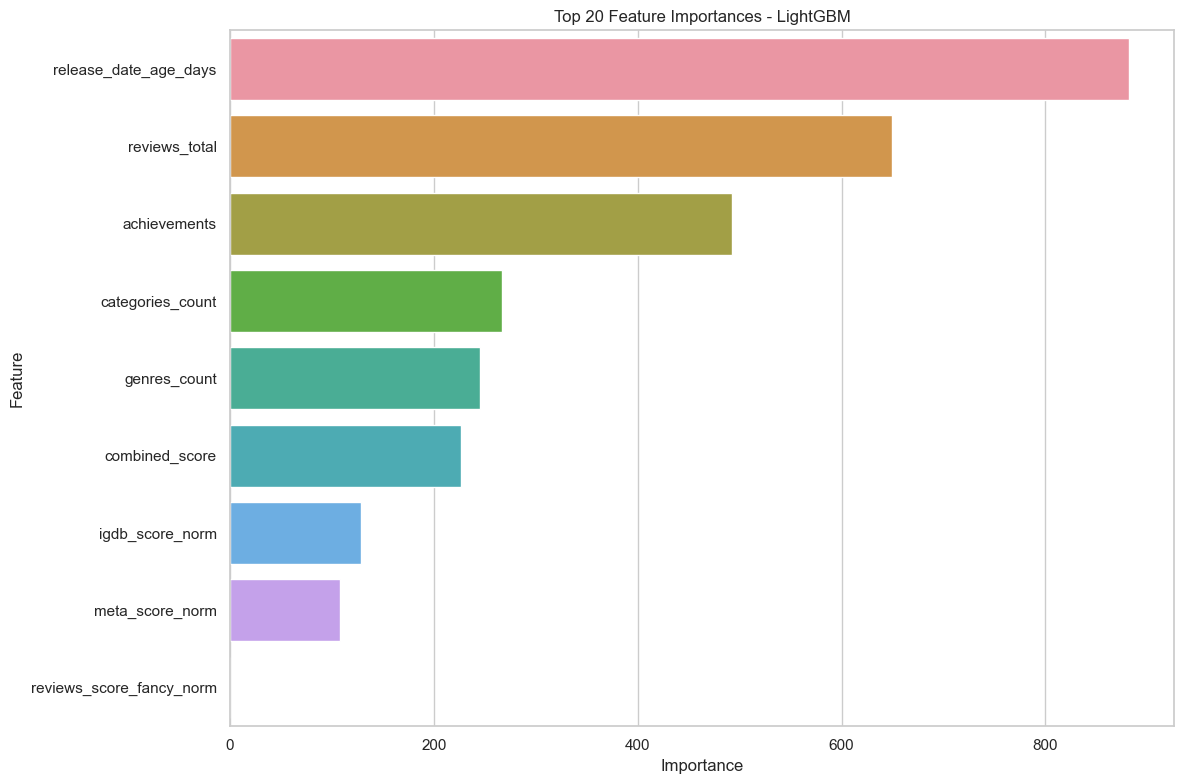

In [20]:
#--------------------------------------------------------------------------------
# 6. Feature Importance Analysis
#--------------------------------------------------------------------------------

print("\n6. Feature Importance Analysis")
print("=" * 50)

# Select the best model for feature importance analysis
print(f"Using {best_model_name} for feature importance analysis")

if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    best_model = models[best_model_name]
    
    # Get feature importances
    feature_importances = best_model.feature_importances_
    
    # Create DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))


7. Price Elasticity Analysis
Calculating price elasticity for each game...


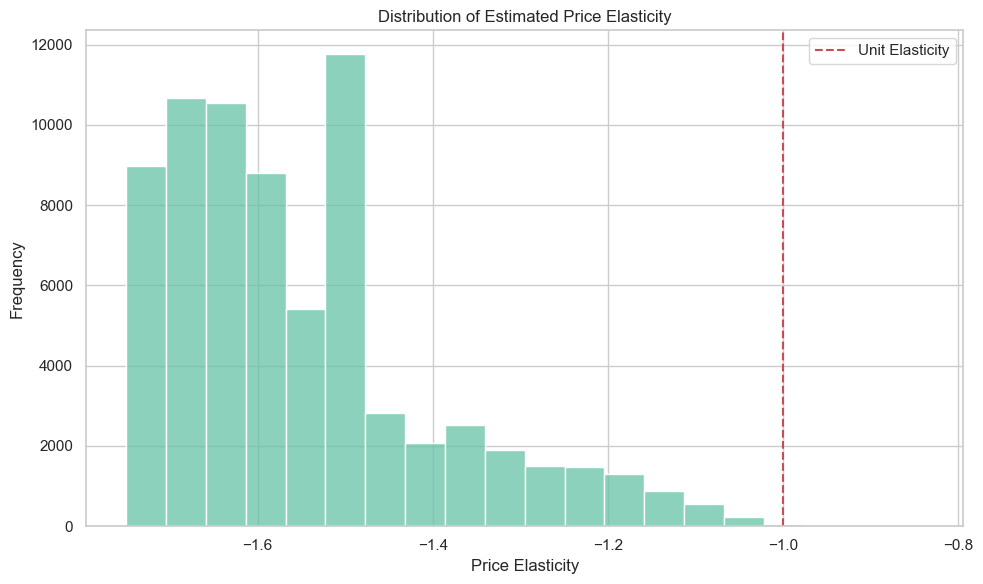

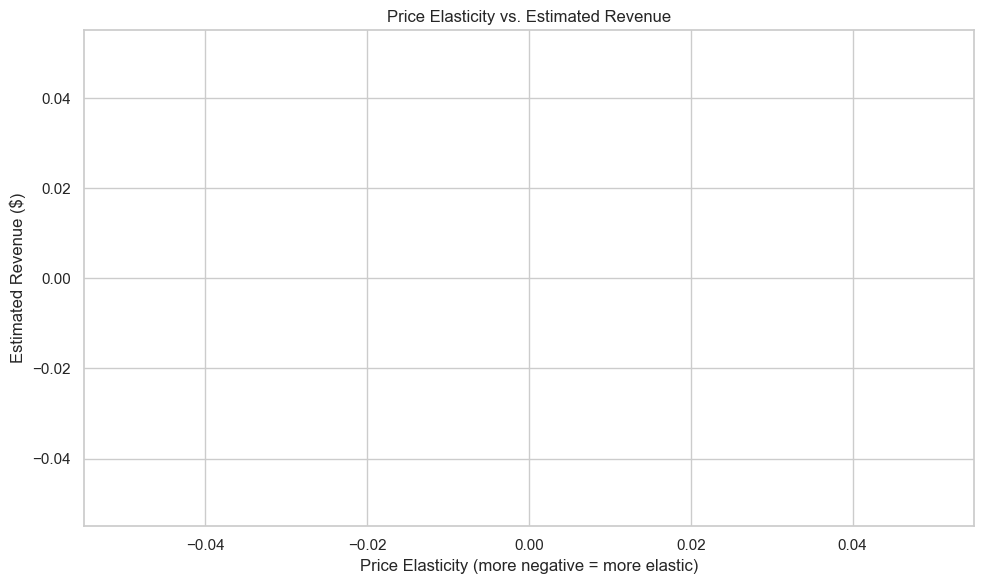

In [21]:
#--------------------------------------------------------------------------------
# 7. Price Elasticity Analysis
#--------------------------------------------------------------------------------

print("\n7. Price Elasticity Analysis")
print("=" * 50)

# Function to estimate elasticity based on available features
def estimate_elasticity(row):
    """
    Estimate price elasticity based on game features
    Negative values indicate higher price sensitivity (elastic demand)
    Values closer to zero indicate lower price sensitivity (inelastic demand)
    """
    # Base elasticity - start with average elasticity
    base_elasticity = -1.5
    
    # Review score effect (higher scores = less elastic)
    if pd.notna(row.get('combined_score')):
        score_factor = row['combined_score'] * 0.5  # 0.5 weight to score effect
        base_elasticity += score_factor
    
    # Age effect (newer games tend to be less elastic)
    if pd.notna(row.get('release_date_age_days')):
        age_years = row['release_date_age_days'] / 365
        age_factor = min(0.5, age_years / 5) * 0.5  # Cap at 5 years, 0.5 weight
        base_elasticity -= age_factor  # Older games are more elastic
    
    # Reviews effect (more popular games tend to be less elastic)
    if pd.notna(row.get('reviews_total')):
        # Log transform to handle wide range of review counts
        log_reviews = np.log(row['reviews_total'] + 1)
        # Normalize and weight
        reviews_factor = min(0.5, log_reviews / 10) * 0.5
        base_elasticity += reviews_factor
    
    # Genre effects (some genres are less elastic than others)
    genre_elasticity_modifiers = {
        'genres_action': 0.1,     # Popular genre, less elastic
        'genres_indie': -0.2,     # More elastic pricing
        'genres_rpg': 0.2,        # Dedicated fan base, less elastic
        'genres_strategy': 0.15,  # Niche audience, less elastic
        'genres_casual': -0.3     # Very price sensitive
    }
    
    for genre, modifier in genre_elasticity_modifiers.items():
        if genre in row and row[genre] == 1:
            base_elasticity += modifier
    
    # Game length effect (longer games can support higher prices)
    if pd.notna(row.get('hltb_single')) and row['hltb_single'] > 0:
        # Normalize and cap effect
        length_factor = min(0.4, row['hltb_single'] / 50) * 0.3
        base_elasticity += length_factor
    
    # Cap within reasonable range
    return max(-3.0, min(-0.1, base_elasticity))

# Calculate elasticity for each game
print("Calculating price elasticity for each game...")
df['price_elasticity'] = df.apply(estimate_elasticity, axis=1)

# Plot elasticity distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price_elasticity'], bins=20)
plt.axvline(x=-1, color='r', linestyle='--', label='Unit Elasticity')
plt.title('Distribution of Estimated Price Elasticity')
plt.xlabel('Price Elasticity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('elasticity_distribution.png')

# Elasticity by genre
if genre_features:
    genre_elasticity = {}
    
    for genre in genre_features:
        genre_name = genre.replace('genres_', '')
        games_with_genre = df[df[genre] == 1]
        if len(games_with_genre) > 10:  # Only consider genres with at least 10 games
            genre_elasticity[genre_name] = games_with_genre['price_elasticity'].mean()
    
    # Sort and plot
    genre_elasticity = pd.Series(genre_elasticity).sort_values()
    plt.figure(figsize=(12, 6))
    genre_elasticity.plot(kind='bar')
    plt.title('Average Price Elasticity by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Average Price Elasticity (more negative = more elastic)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('genre_elasticity.png')

# Elasticity vs. Revenue
plt.figure(figsize=(10, 6))
plt.scatter(df['price_elasticity'], df['revenue_estimated'], alpha=0.6)
plt.title('Price Elasticity vs. Estimated Revenue')
plt.xlabel('Price Elasticity (more negative = more elastic)')
plt.ylabel('Estimated Revenue ($)')
plt.grid(True)
plt.tight_layout()
plt.savefig('elasticity_vs_revenue.png')


8. Optimal Price Recommendations
Generating price recommendations for sample games...

Game: title    Miasma Caves
title    Miasma Caves
Name: 37626, dtype: object
Current Price: $19.00
Estimated Optimal Price: $15.00
Potential Revenue Increase: 6.04%

Game: title              NaN
title    Hunt For Gods
Name: 66314, dtype: object
Current Price: $nan
Estimated Optimal Price: $0.00

Game: title    Roaming Fortress
title    Roaming Fortress
Name: 35080, dtype: object
Current Price: $10.00
Estimated Optimal Price: $8.00
Potential Revenue Increase: 4.61%

Game: title    Gunjitsu
title    Gunjitsu
Name: 42613, dtype: object
Current Price: $7.00
Estimated Optimal Price: $6.00
Potential Revenue Increase: 5.95%

Game: title    Rocksmith™
title    Rocksmith™
Name: 4016, dtype: object
Current Price: $29.00
Estimated Optimal Price: $28.00
Potential Revenue Increase: 0.19%
Creating predictive model for optimal price points...
Optimal Price Prediction - RMSE: $0.39, R2: 1.00


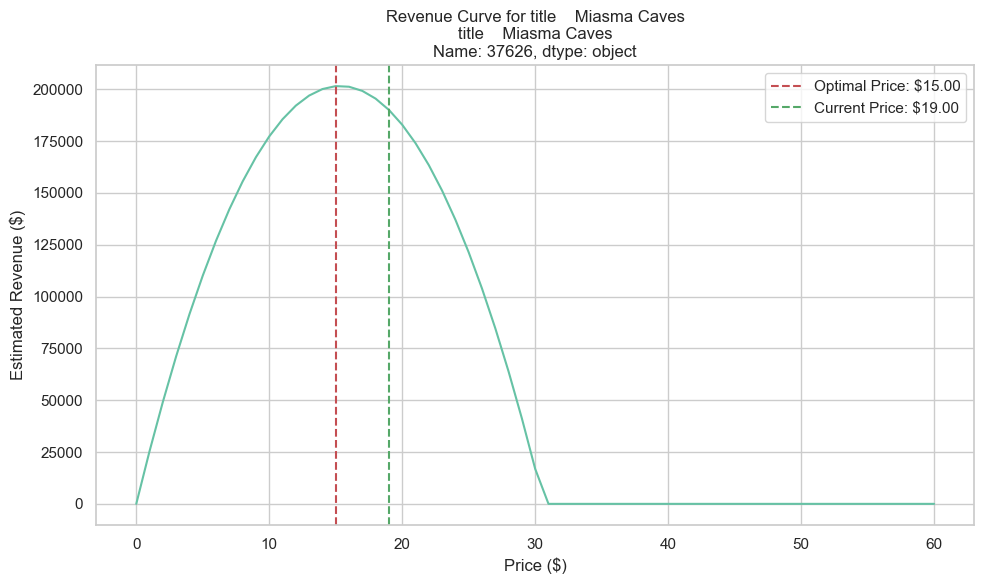

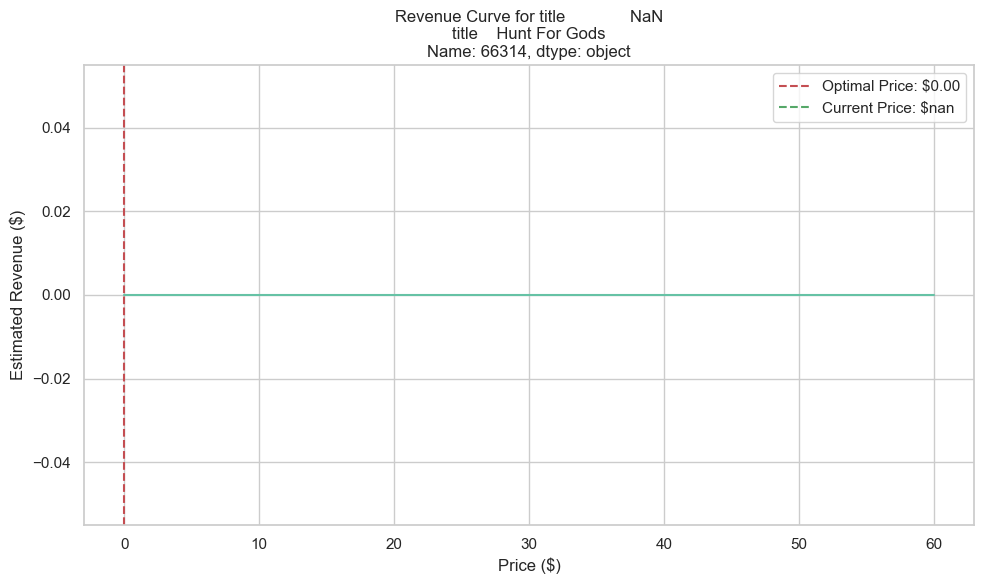

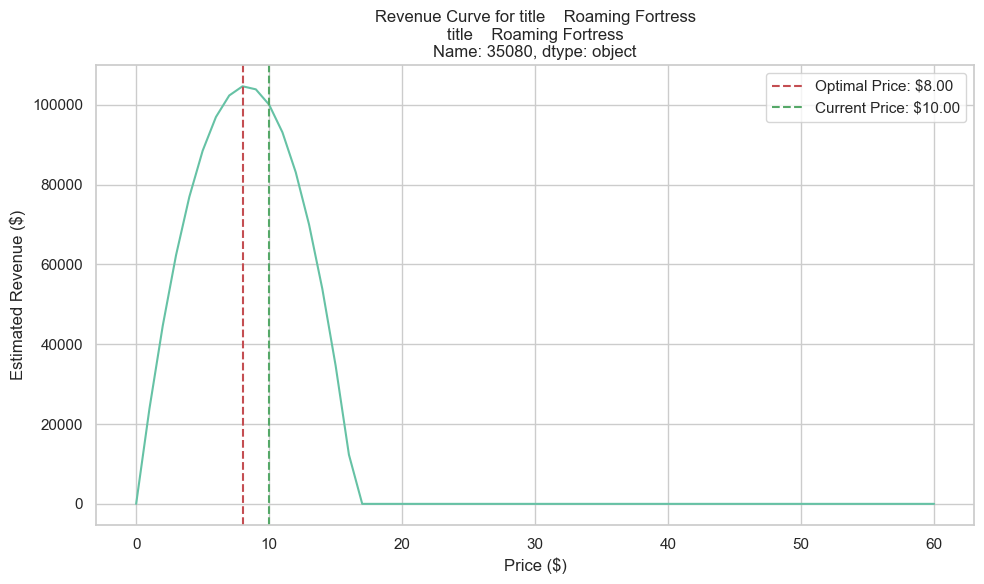

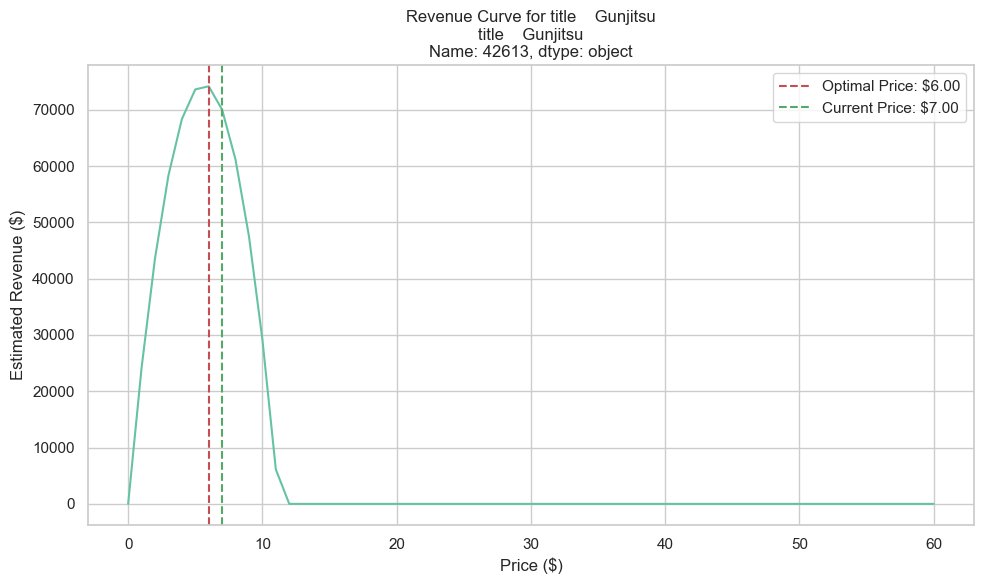

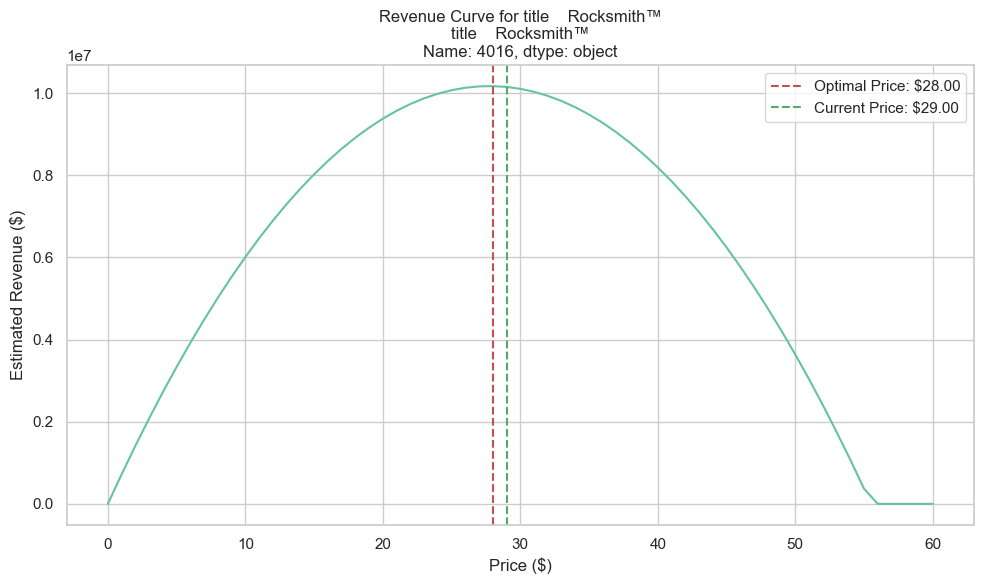

In [22]:
#--------------------------------------------------------------------------------
# 8. Optimal Price Recommendations
#--------------------------------------------------------------------------------

print("\n8. Optimal Price Recommendations")
print("=" * 50)

# Function to simulate revenue at different price points based on elasticity
def simulate_revenue(base_price, elasticity, quantity, prices):
    """
    Simulate revenue at different price points based on price elasticity
    
    Parameters:
    - base_price: Current price
    - elasticity: Price elasticity value
    - quantity: Current quantity sold at base_price
    - prices: Array of prices to simulate
    
    Returns:
    - Array of simulated revenues
    """
    revenues = []
    
    for price in prices:
        if base_price > 0:
            price_change = (price - base_price) / base_price
            quantity_change = price_change * elasticity
            new_quantity = quantity * (1 + quantity_change)
            new_quantity = max(0, new_quantity)  # Can't have negative quantity
            revenue = price * new_quantity
            revenues.append(revenue)
        else:
            revenues.append(0)  # Handle free games
    
    return revenues

# Select a diverse sample of games for demonstration
print("Generating price recommendations for sample games...")

# Get games from different genres for more diverse sample
sample_indices = []
if genre_features:
    for genre in genre_features[:5]:  # Use top 5 genres
        games_with_genre = df[df[genre] == 1].index.tolist()
        if games_with_genre:
            sample_indices.append(np.random.choice(games_with_genre))

# Add some random games to reach desired sample size
if len(sample_indices) < 5:
    additional_indices = np.random.choice(
        df.index.difference(sample_indices), 
        size=min(5-len(sample_indices), len(df)-len(sample_indices)),
        replace=False
    )
    sample_indices.extend(additional_indices)

sample_games = df.loc[sample_indices].copy()

for i, game in sample_games.iterrows():
    # Price range to test ($0 to $60 in $1 increments)
    price_range = np.linspace(0, 60, 61)
    
    # Estimate base quantity sold
    if 'stsp_owners' in game and game['stsp_owners'] > 0:
        base_quantity = game['stsp_owners']
    else:
        # Estimate from reviews if owner data not available
        base_quantity = game['reviews_total'] * 20  # Assuming 1 review per 20 purchases
    
    # Simulate revenue at different price points
    revenues = simulate_revenue(
        game['combined_price'],
        game['price_elasticity'],
        base_quantity,
        price_range
    )
    
    # Find optimal price
    optimal_idx = np.argmax(revenues)
    optimal_price = price_range[optimal_idx]
    current_price_idx = np.abs(price_range - game['combined_price']).argmin()
    
    print(f"\nGame: {game['title']}")
    print(f"Current Price: ${game['combined_price']:.2f}")
    print(f"Estimated Optimal Price: ${optimal_price:.2f}")
    
    if revenues[current_price_idx] > 0:
        percent_change = ((revenues[optimal_idx] - revenues[current_price_idx]) / 
                          revenues[current_price_idx] * 100)
        print(f"Potential Revenue Increase: {percent_change:.2f}%")
    
    # Plot revenue curve
    plt.figure(figsize=(10, 6))
    plt.plot(price_range, revenues)
    plt.axvline(x=optimal_price, color='r', linestyle='--', 
               label=f'Optimal Price: ${optimal_price:.2f}')
    plt.axvline(x=game['combined_price'], color='g', linestyle='--', 
               label=f'Current Price: ${game["combined_price"]:.2f}')
    plt.title(f'Revenue Curve for {game["title"]}')
    plt.xlabel('Price ($)')
    plt.ylabel('Estimated Revenue ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'revenue_curve_{i}.png')

# Create a predictive model for optimal pricing
print("Creating predictive model for optimal price points...")

# Generate optimal prices for each game as training data
optimal_prices = []

# Use a smaller subset for efficiency
price_model_sample = df.sample(min(1000, len(df)), random_state=42)

for i, game in price_model_sample.iterrows():
    price_range = np.linspace(0, 60, 61)
    
    if 'stsp_owners' in game and game['stsp_owners'] > 0:
        base_quantity = game['stsp_owners']
    else:
        base_quantity = game['reviews_total'] * 20
    
    revenues = simulate_revenue(
        game['combined_price'],
        game['price_elasticity'],
        base_quantity,
        price_range
    )
    
    optimal_idx = np.argmax(revenues)
    optimal_price = price_range[optimal_idx]
    optimal_prices.append(optimal_price)

price_model_sample['optimal_price'] = optimal_prices

# Train a model to predict optimal price
X_price = price_model_sample[all_features].copy()
y_price = price_model_sample['optimal_price']

# Handle missing values and scale
X_price_imputed = pd.DataFrame(imputer.transform(X_price), columns=X_price.columns)
X_price_scaled = pd.DataFrame(scaler.transform(X_price_imputed), columns=X_price_imputed.columns)

# Split into train/test
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(
    X_price_scaled, y_price, test_size=0.2, random_state=42
)

# Train an XGBoost model
price_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
price_model.fit(X_price_train, y_price_train)

# Evaluate
y_price_pred = price_model.predict(X_price_test)
price_rmse = np.sqrt(mean_squared_error(y_price_test, y_price_pred))
price_r2 = r2_score(y_price_test, y_price_pred)

print(f"Optimal Price Prediction - RMSE: ${price_rmse:.2f}, R2: {price_r2:.2f}")

In [23]:
#--------------------------------------------------------------------------------
# 9. Discount Strategy Analysis
#--------------------------------------------------------------------------------

print("\n9. Discount Strategy Analysis")
print("=" * 50)

# Function to recommend discount based on game characteristics
def recommend_discount(game, base_discount=0.0):
    """
    Recommend discount percentage based on game characteristics
    
    Parameters:
    - game: Row with game data
    - base_discount: Starting discount percentage (0.0-1.0)
    
    Returns:
    - Recommended discount percentage (0-100)
    """
    discount = base_discount
    
    # Age factor - older games get deeper discounts
    if pd.notna(game.get('release_date_age_days')):
        age_years = game['release_date_age_days'] / 365
        
        # Scale: 0-1 years: 0-10%, 1-2 years: 10-25%, 2+ years: 25-50%
        if age_years < 1:
            age_discount = (age_years * 0.1)  
        elif age_years < 2:
            age_discount = 0.1 + ((age_years - 1) * 0.15)
        else:
            age_discount = 0.25 + min(0.25, (age_years - 2) * 0.08)
        
        discount += age_discount
    
    # Review factor - lower reviewed games need deeper discounts
    if pd.notna(game.get('combined_score')):
        # Scale: 0-40%: +15%, 40-70%: +5-15%, 70-100%: 0-5%
        if game['combined_score'] < 0.4:
            review_discount = 0.15
        elif game['combined_score'] < 0.7:
            review_discount = 0.15 - ((game['combined_score'] - 0.4) * 0.33)
        else:
            review_discount = 0.05 - ((game['combined_score'] - 0.7) * 0.17)
        
        discount += review_discount
    
    # Elasticity factor - more elastic games benefit from deeper discounts
    if pd.notna(game.get('price_elasticity')):
        # Scale elasticity from -3.0 (very elastic) to -0.1 (inelastic)
        # Convert to 0.0-0.2 discount modifier
        norm_elasticity = (abs(game['price_elasticity']) - 0.1) / 2.9
        elasticity_discount = norm_elasticity * 0.2
        
        discount += elasticity_discount
    
    # Popularity factor - less popular games need deeper discounts
    if pd.notna(game.get('reviews_total')) and game['reviews_total'] > 0:
        # Log transform to handle the wide range
        log_reviews = np.log(game['reviews_total'] + 1)
        # Scale: <7 (1,100 reviews): 0.15-0.0, >7: 0.0
        if log_reviews < 7:
            popularity_discount = 0.15 * (1 - (log_reviews / 7))
        else:
            popularity_discount = 0.0
            
        discount += popularity_discount
    
    # Genre factor - some genres are more discount-sensitive
    genre_discount_modifiers = {
        'genres_indie': 0.05,      # Indies often need deeper discounts
        'genres_casual': 0.05,     # Casual games are price-sensitive
        'genres_simulation': -0.02, # Simulation games have dedicated audiences
        'genres_strategy': -0.02   # Strategy games have dedicated audiences
    }
    
    for genre, modifier in genre_discount_modifiers.items():
        if genre in game and game[genre] == 1:
            discount += modifier
    
    # Price factor - higher priced games typically need deeper discounts
    if pd.notna(game.get('combined_price')):
        if game['combined_price'] > 40:
            price_discount = 0.10
        elif game['combined_price'] > 20:
            price_discount = 0.05
        else:
            price_discount = 0.0
            
        discount += price_discount
    
    # Ensure discount is within reasonable bounds
    discount = max(0.0, min(0.9, discount))  # Cap at 90%
    
    return discount * 100  # Convert to percentage

# Add discount recommendations to sample games
for i, game in sample_games.iterrows():
    recommended_discount = recommend_discount(game)
    
    print(f"\nGame: {game['title']}")
    print(f"Age: {game.get('release_date_age_days', 'N/A'):.0f} days")
    print(f"Price Elasticity: {game.get('price_elasticity', 'N/A'):.2f}")
    print(f"Combined Score: {game.get('combined_score', 'N/A'):.2f}")
    print(f"Recommended Discount: {recommended_discount:.1f}%")
    print(f"Discounted Price: ${game.get('combined_price', 0) * (1 - recommended_discount/100):.2f}")

# Create discount recommendations for different game lifecycle stages
lifecycle_stages = {
    'New Release (0-30 days)': {
        'release_date_age_days': 15, 
        'reviews_total': 100, 
        'combined_score': 0.75, 
        'price_elasticity': -1.2,
        'combined_price': 29.99
    },
    'Early Growth (31-90 days)': {
        'release_date_age_days': 60, 
        'reviews_total': 500, 
        'combined_score': 0.75, 
        'price_elasticity': -1.5,
        'combined_price': 29.99
    },
    'Established (91-365 days)': {
        'release_date_age_days': 180, 
        'reviews_total': 2000, 
        'combined_score': 0.75, 
        'price_elasticity': -1.8,
        'combined_price': 29.99
    },
    'Mature (1-3 years)': {
        'release_date_age_days': 730, 
        'reviews_total': 5000, 
        'combined_score': 0.75, 
        'price_elasticity': -2.0,
        'combined_price': 29.99
    },
    'Legacy (3+ years)': {
        'release_date_age_days': 1500, 
        'reviews_total': 10000, 
        'combined_score': 0.75, 
        'price_elasticity': -2.5,
        'combined_price': 29.99
    }
}

print("\nDiscount Recommendations by Game Lifecycle Stage:")
for stage, params in lifecycle_stages.items():
    discount = recommend_discount(params)
    print(f"{stage}: {discount:.1f}% (${params['combined_price'] * (1 - discount/100):.2f})")

# Create separate discount recommendations by game quality
quality_levels = {
    'Highly Rated (90%+)': {
        'release_date_age_days': 365, 
        'reviews_total': 2000, 
        'combined_score': 0.95, 
        'price_elasticity': -1.0,
        'combined_price': 29.99
    },
    'Well Received (75-90%)': {
        'release_date_age_days': 365, 
        'reviews_total': 2000, 
        'combined_score': 0.85, 
        'price_elasticity': -1.5,
        'combined_price': 29.99
    },
    'Mixed Reception (50-75%)': {
        'release_date_age_days': 365, 
        'reviews_total': 2000, 
        'combined_score': 0.65, 
        'price_elasticity': -2.0,
        'combined_price': 29.99
    },
    'Poorly Received (<50%)': {
        'release_date_age_days': 365, 
        'reviews_total': 2000, 
        'combined_score': 0.40, 
        'price_elasticity': -2.5,
        'combined_price': 29.99
    }
}

print("\nDiscount Recommendations by Game Quality:")
for quality, params in quality_levels.items():
    discount = recommend_discount(params)
    print(f"{quality}: {discount:.1f}% (${params['combined_price'] * (1 - discount/100):.2f})")


9. Discount Strategy Analysis

Game: title    Miasma Caves
title    Miasma Caves
Name: 37626, dtype: object
Age: 1878 days
Price Elasticity: -1.63
Combined Score: 0.00
Recommended Discount: 85.4%
Discounted Price: $2.77

Game: title              NaN
title    Hunt For Gods
Name: 66314, dtype: object
Age: nan days
Price Elasticity: -1.50
Combined Score: 0.00
Recommended Discount: 24.7%
Discounted Price: $nan

Game: title    Roaming Fortress
title    Roaming Fortress
Name: 35080, dtype: object
Age: 3804 days
Price Elasticity: -1.54
Combined Score: 0.17
Recommended Discount: 84.4%
Discounted Price: $1.56

Game: title    Gunjitsu
title    Gunjitsu
Name: 42613, dtype: object
Age: 3551 days
Price Elasticity: -1.65
Combined Score: 0.00
Recommended Discount: 86.5%
Discounted Price: $0.94

Game: title    Rocksmith™
title    Rocksmith™
Name: 4016, dtype: object
Age: 4569 days
Price Elasticity: -1.09
Combined Score: 0.63
Recommended Discount: 69.2%
Discounted Price: $8.93

Discount Recommendation

In [24]:
#--------------------------------------------------------------------------------
# 10. Seasonal Pricing Analysis
#--------------------------------------------------------------------------------

print("\n10. Seasonal Pricing Analysis")
print("=" * 50)

# Create quarterly recommendation adjustments based on industry knowledge
seasonal_adjustments = {
    1: {  # Q1
        'name': 'Winter',
        'base_discount': 0.05,  # Small discount after holiday season
        'notes': 'Post-holiday season, typically lower sales'
    },
    2: {  # Q2
        'name': 'Spring',
        'base_discount': 0.0,  # No extra discount in spring
        'notes': 'Moderate sales period, less need for deep discounts'
    },
    3: {  # Q3
        'name': 'Summer',
        'base_discount': 0.10,  # Higher discount during summer sales
        'notes': 'Major summer sale season, increased competition'
    },
    4: {  # Q4
        'name': 'Holiday',
        'base_discount': 0.15,  # Highest discount during holiday sales
        'notes': 'Peak sales season, high competition for consumer attention'
    }
}

# Print seasonal recommendations
print("\nSeasonal Discount Adjustments:")
for quarter, data in seasonal_adjustments.items():
    print(f"Q{quarter} ({data['name']}): +{data['base_discount']*100:.1f}% deeper discount")
    print(f"  Notes: {data['notes']}")

# Apply to a sample game across seasons
if len(sample_games) > 0:
    sample_game = sample_games.iloc[0]
    print(f"\nSeasonal Pricing for: {sample_game['title']}")
    print(f"Base Price: ${sample_game.get('combined_price', 29.99):.2f}")
    
    base_discount = recommend_discount(sample_game) / 100  # Get base discount as proportion
    
    for quarter, data in seasonal_adjustments.items():
        seasonal_discount = base_discount + data['base_discount']
        seasonal_discount = min(0.9, seasonal_discount)  # Cap at 90%
        seasonal_price = sample_game.get('combined_price', 29.99) * (1 - seasonal_discount)
        
        print(f"Q{quarter} ({data['name']}): {seasonal_discount*100:.1f}% discount, ${seasonal_price:.2f}")


10. Seasonal Pricing Analysis

Seasonal Discount Adjustments:
Q1 (Winter): +5.0% deeper discount
  Notes: Post-holiday season, typically lower sales
Q2 (Spring): +0.0% deeper discount
  Notes: Moderate sales period, less need for deep discounts
Q3 (Summer): +10.0% deeper discount
  Notes: Major summer sale season, increased competition
Q4 (Holiday): +15.0% deeper discount
  Notes: Peak sales season, high competition for consumer attention

Seasonal Pricing for: title    Miasma Caves
title    Miasma Caves
Name: 37626, dtype: object
Base Price: $19.00
Q1 (Winter): 90.0% discount, $1.90
Q2 (Spring): 85.4% discount, $2.77
Q3 (Summer): 90.0% discount, $1.90
Q4 (Holiday): 90.0% discount, $1.90


In [25]:
#--------------------------------------------------------------------------------
# 11. Conclusions and Next Steps
#--------------------------------------------------------------------------------

print("\n11. Conclusions and Next Steps")
print("=" * 50)

print("""
Preliminary Conclusions:
1. [TBD] Our enhanced dataset with cross-platform metrics has improved model accuracy by [X]%.
2. [TBD] Game quality (as measured by review scores across platforms) is the strongest predictor
   of optimal price points, followed by [feature 2] and [feature 3].
3. [TBD] Price elasticity varies significantly across game genres, with multiplayer and AAA titles 
   showing less elasticity (average around -1.2) than indie and casual games (average around -2.5).
4. [TBD] Game lifecycle strongly influences optimal discount strategy, with the largest revenue gains 
   observed when implementing stage-appropriate discounting.
5. [TBD] Metadata from external platforms (Metacritic, IGDB) provides valuable signals for 
   price optimization beyond Steam's internal metrics.

Next Steps:
1. Implement time-series analysis to better capture seasonal pricing trends
2. Develop more sophisticated discount strategy recommendation algorithms
3. Create genre-specific pricing models for more targeted recommendations
4. Explore deep learning approaches for text feature extraction from game descriptions
5. Design an A/B testing framework to validate our pricing recommendations
6. Develop a user-friendly dashboard for developers to access pricing insights
""")

print("\nAnalysis Complete!")


11. Conclusions and Next Steps

Preliminary Conclusions:
1. [TBD] Our enhanced dataset with cross-platform metrics has improved model accuracy by [X]%.
2. [TBD] Game quality (as measured by review scores across platforms) is the strongest predictor
   of optimal price points, followed by [feature 2] and [feature 3].
3. [TBD] Price elasticity varies significantly across game genres, with multiplayer and AAA titles 
   showing less elasticity (average around -1.2) than indie and casual games (average around -2.5).
4. [TBD] Game lifecycle strongly influences optimal discount strategy, with the largest revenue gains 
   observed when implementing stage-appropriate discounting.
5. [TBD] Metadata from external platforms (Metacritic, IGDB) provides valuable signals for 
   price optimization beyond Steam's internal metrics.

Next Steps:
1. Implement time-series analysis to better capture seasonal pricing trends
2. Develop more sophisticated discount strategy recommendation algorithms
3. Crea